# Binary Classification

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from scipy.stats import multinomial

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.pipeline import Pipeline

from copy import deepcopy

In [2]:
#Additional imports to "translate" emoji
from transformers import AutoTokenizer
import emoji

In [3]:
df = pd.read_csv("data/stock_tweets.csv")
df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [5]:
df["Stock Name"].value_counts()

Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

Changing stock names for binary classification.

MAMAA: 1, MAMMA: 0

In [6]:
df["Stock Name"] = df["Stock Name"].replace({"TSLA": 0, "TSM": 0, "AAPL": 1, "PG": 0, "AMZN": 1, "MSFT": 1, "NIO": 0, "META": 1, "AMD": 0,
"NFLX": 0, "GOOG": 1, "PYPL": 0, "DIS": 0, "BA": 0, "COST": 0, "INTC": 0, "KO": 0, "CRM": 0, "XPEV": 0, "ENPH": 0, "ZS": 0, "VZ": 0, 
"BX": 0, "NOC": 0, "NVDA": 0, "F": 0}, regex=True)
df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,0,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,0,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,0,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",0,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,0,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",0,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,0,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",0,XPeng Inc.


In [7]:
df["Stock Name"].value_counts()

Stock Name
0    63517
1    17276
Name: count, dtype: int64

This dataset is imbalanced due number of non-MAMAA stocks. Most of that category is weighed by Tesla. We can make a guess that this due to the
timing when this dataset was scrapped as the news cycle in this time period was Elon Musk considering buying Twitter and its purchase.

In [8]:
def emojidescription(text):
  return emoji.replace_emoji(text, replace=lambda chars, data_dict: " ".join(data_dict["en"].split("_")).strip(":"))

In [9]:
df["EmojiToken"] = df["Tweet"].apply(emojidescription)
df

,Date,Tweet,Stock Name,Company Name,EmojiToken
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,0,"Tesla, Inc.",Mainstream media has done an amazing job at br...
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,0,"Tesla, Inc.",Tesla delivery estimates are at around 364k fr...
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,0,"Tesla, Inc.",3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0,"Tesla, Inc.",@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",0,"Tesla, Inc.","@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,0,XPeng Inc.,Some of the fastest growing tech stocks on the...
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",0,XPeng Inc.,"With earnings on the horizon, here is a quick ..."
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,0,XPeng Inc.,Our record delivery results are a testimony of...
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",0,XPeng Inc.,"We delivered 10,412 Smart EVs in Sep 2021, rea..."


In [10]:
#Added these stop words after the initial normalization step
addstopwords = ["@", "amp"]

stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(addstopwords)
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
def clean(tweets):
    retext = re.sub("((www.[^s]+)|(https?://[^s]+))", " ", tweets)

    tokenizer = TweetTokenizer(reduce_len=True, strip_handles=True)
    tokens = tokenizer.tokenize(retext)

    stoptokens = [token.lower() for token in tokens if ((token.isalpha()) & (token.lower() not in stopwords))]

    stemmer = SnowballStemmer(language="english")
    stems = [stemmer.stem(word) for word in stoptokens]
    return stems

In [12]:
df["TweetNorm"] = df["EmojiToken"].apply(clean)
df.sample(20)

,Date,Tweet,Stock Name,Company Name,EmojiToken,TweetNorm
24782,2022-01-12 20:42:38+00:00,Experienced connectivity issues with Tidal ear...,0,"Tesla, Inc.",Experienced connectivity issues with Tidal ear...,"[experienc, connect, issu, tidal, earlier, tod..."
31482,2021-11-12 15:45:39+00:00,Are you all watching how much time/effort/mone...,0,"Tesla, Inc.",Are you all watching how much time/effort/mone...,"[watch, much, time, effort, money, rivian, nee..."
17310,2022-03-29 11:51:04+00:00,"I just sold my 1,000 shares from yesterday pur...",0,"Tesla, Inc.","I just sold my 1,000 shares from yesterday pur...","[sold, share, yesterday, purchas, pm, yes, one..."
51343,2022-01-30 18:32:57+00:00,"Heavy-weight week: (1) Tue, Wedn &amp; Thur fe...",1,"Amazon.com, Inc.","Heavy-weight week: (1) Tue, Wedn &amp; Thur fe...","[week, tue, wedn, thur, featur, four, top, ten..."
51126,2022-02-03 21:22:28+00:00,Wow wow wow \n\nWent bullish $Amzn at 2760 now...,1,"Amazon.com, Inc.",Wow wow wow \n\nWent bullish $Amzn at 2760 now...,"[wow, wow, wow, went, bullish, amzn]"
36784,2021-10-06 21:20:30+00:00,In Q3 in the U.S.:\n\nModel 3 outsold ALL BMW ...,0,"Tesla, Inc.",In Q3 in the U.S.:\n\nModel 3 outsold ALL BMW ...,"[u, model, outsold, bmw, passeng, car, k, k, m..."
18137,2022-03-22 17:39:41+00:00,"""It's Fair to say that without @Tesla the rest...",0,"Tesla, Inc.","""It's Fair to say that without @Tesla the rest...","[fair, say, without, rest, industri, move, fas..."
72690,2021-11-02 19:14:13+00:00,Buddha accidentally closed out the video in th...,0,Taiwan Semiconductor Manufacturing Company Lim...,Buddha accidentally closed out the video in th...,"[buddha, accident, close, video, middl, big, a..."
27615,2021-12-21 16:39:37+00:00,BREAKING: I think @elonmusk is done selling $T...,0,"Tesla, Inc.",BREAKING: I think @elonmusk is done selling $T...,"[break, think, done, sell, tsla, stock, year, ..."
11570,2022-05-17 22:44:28+00:00,Market not reacting to AI Day #2 but I’m happy...,0,"Tesla, Inc.",Market not reacting to AI Day #2 but I’m happy...,"[market, react, ai, day, happi, elon, tweet, t..."


In [13]:
df["TweetNorm"] = df["TweetNorm"].apply(" ".join)

In [14]:
df_class = df.filter(["Stock Name", "TweetNorm"], axis=1)
df_class

,Stock Name,TweetNorm
0,0,mainstream media done amaz job brainwash peopl...
1,0,tesla deliveri estim around analyst tsla
2,0,even includ unvest rsus addit equiti need rsus...
3,0,hahaha still tri stop tesla fsd bro get shit t...
4,0,stop tri kill kid sad derang old man
...,...,...
80788,0,fastest grow tech stock market mix upst xpev a...
80789,0,earn horizon quick snapshot largest increas co...
80790,0,record deliveri result testimoni unwav pursuit...
80791,0,deliv smart ev sep reach mileston unit month d...


In [15]:
X = df_class["TweetNorm"]
y = df_class["Stock Name"]

In [16]:
df_class["TweetNorm"]

0        mainstream media done amaz job brainwash peopl...
1                 tesla deliveri estim around analyst tsla
2        even includ unvest rsus addit equiti need rsus...
3        hahaha still tri stop tesla fsd bro get shit t...
4                     stop tri kill kid sad derang old man
                               ...                        
80788    fastest grow tech stock market mix upst xpev a...
80789    earn horizon quick snapshot largest increas co...
80790    record deliveri result testimoni unwav pursuit...
80791    deliv smart ev sep reach mileston unit month d...
80792    xpeng deliv outstand perform extrem condit ceo...
Name: TweetNorm, Length: 80793, dtype: object

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=59)

In [18]:
countvector = [("countvector", CountVectorizer(min_df=0.05, max_df=0.95))]
pipeline = Pipeline(countvector)

In [19]:
X_tr_proc = pipeline.fit_transform(X_train)

In [20]:
X_tr_proc

<56555x22 sparse matrix of type '<class 'numpy.int64'>'
	with 115082 stored elements in Compressed Sparse Row format>

In [21]:
featurenames = pipeline["countvector"].get_feature_names_out()
pd.DataFrame(X_tr_proc.toarray(), columns=featurenames)

,aapl,amd,amzn,buy,day,face,fb,get,go,like,...,nflx,nvda,share,stock,tesla,today,tsla,tsm,week,year
0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
56551,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
56552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
56553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Naive Bayes with Multinomial Distribution Likelihood


In [22]:
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

Stock Name
0    0.785908
1    0.214092
Name: count, dtype: float64

Bag of Words

In [23]:
bow = pd.DataFrame(X_tr_proc.toarray(), columns=featurenames)
bow["target"] = y_train
bow

,aapl,amd,amzn,buy,day,face,fb,get,go,like,...,nvda,share,stock,tesla,today,tsla,tsm,week,year,target
0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,NaN
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
3,1,1,1,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0.0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,1,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.0
56551,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1.0
56552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0
56553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1.0


In [24]:
class1_bow_mat = bow[bow["target"] == 1].drop(columns = ["target"])

N_tok_1 = class1_bow_mat.sum(axis = 0) 
N_1 =  class1_bow_mat.values.sum()

prob_c1 = N_tok_1/N_1
prob_c1.sort_values(ascending = False)[0:10]

tsla     0.221566
amzn     0.092588
aapl     0.065482
tesla    0.050489
stock    0.045624
fb       0.038971
week     0.036142
year     0.035000
like     0.034603
day      0.034106
dtype: float64

In [25]:
class0_bow_mat = bow[bow["target"] == 0].drop(columns = ["target"])

N_tok_0 = class0_bow_mat.sum(axis=0)
N_0 =  class0_bow_mat.values.sum() 

prob_c0 = N_tok_0/N_0
prob_c0.sort_values(ascending=False)[0:10]

tsla     0.220847
amzn     0.095249
aapl     0.067649
tesla    0.052569
stock    0.044047
fb       0.038056
like     0.035177
day      0.035060
year     0.033868
face     0.033417
dtype: float64

In [26]:
bow_mat_feat = bow.drop(columns=["target"])
word_vec = bow_mat_feat.iloc[60]
word_vec

aapl      0
amd       0
amzn      0
buy       0
day       0
face      1
fb        0
get       0
go        0
like      0
market    1
msft      0
nflx      0
nvda      0
share     0
stock     0
tesla     0
today     0
tsla      0
tsm       0
week      0
year      1
Name: 60, dtype: int64

In [27]:
article_length = word_vec.sum()
article_length

3

In [28]:
class1_likelihood = multinomial.pmf(x=word_vec.values, n=article_length, p=prob_c1.values)
class0_likelihood = multinomial.pmf(x=word_vec.values, n=article_length, p=prob_c0.values)

In [29]:
print(class1_likelihood*class_priors[1])
print(class0_likelihood*class_priors[0])
print(np.log10(class1_likelihood*class_priors[1]))
print(np.log10(class0_likelihood*class_priors[0]))

4.44941029828223e-05
0.0001734520758941023
-4.351697544338755
-3.760820498105238


Laplace

In [30]:
mod_pipe = deepcopy(pipeline)
mod_pipe.steps.append(("multinb", MultinomialNB()))
mod_pipe.steps

[('countvector', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [31]:
mod_pipe.fit(X_train, y_train)

Pipeline(steps=[('countvector', CountVectorizer(max_df=0.95, min_df=0.05)),
                ('multinb', MultinomialNB())])

In [32]:
y_pred = mod_pipe.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     19070
           1       0.70      0.64      0.67      5168

    accuracy                           0.87     24238
   macro avg       0.80      0.78      0.79     24238
weighted avg       0.86      0.87      0.86     24238



In [34]:
roc_auc_score(y_test, y_pred)

0.7841940581465385

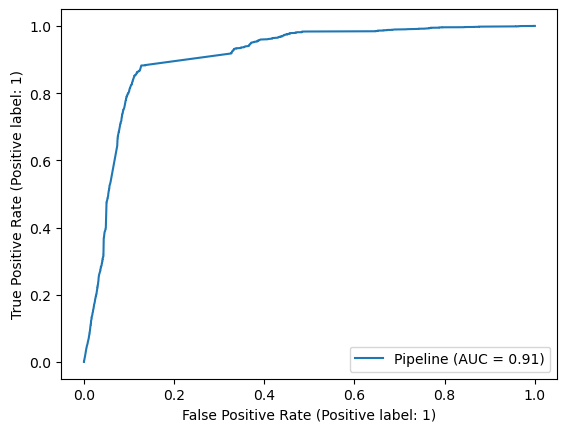

In [35]:
RocCurveDisplay.from_estimator(mod_pipe, X_test, y_test);

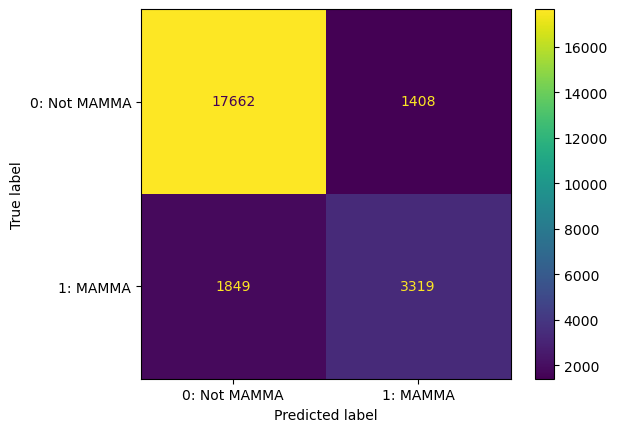

In [36]:
ConfusionMatrixDisplay.from_estimator(mod_pipe, X_test, y_test, display_labels=["0: Not MAMMA", "1: MAMMA"]);

Using TF-IDF + Multinomial NB

In [37]:
tfidfmod_pipe = deepcopy(mod_pipe)
tfidfmod_pipe.steps[0] = ("tfidf", TfidfVectorizer(min_df=0.05, max_df=0.95))
tfidfmod_pipe.steps

[('tfidf', TfidfVectorizer(max_df=0.95, min_df=0.05)),
 ('multinb', MultinomialNB())]

In [38]:
tfidfmod_pipe.fit(X_train, y_train)
ypred_tfidf = tfidfmod_pipe.predict(X_test)

In [39]:
roc_auc_score(y_test, ypred_tfidf)

0.714447515751809

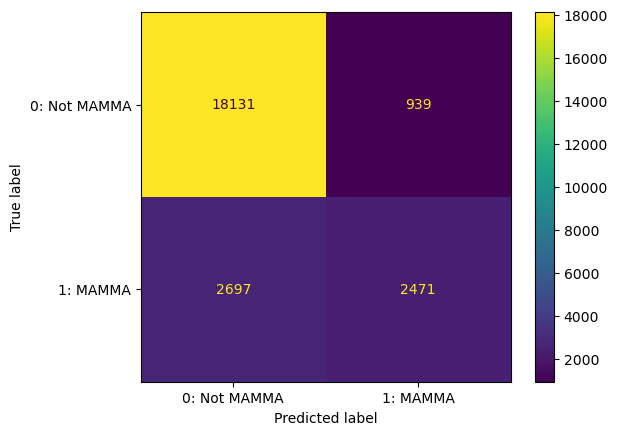

In [40]:
ConfusionMatrixDisplay.from_estimator(tfidfmod_pipe, X_test, y_test, display_labels=["0: Not MAMMA", "1: MAMMA"]);

Count Vectorizer + Complement NB<br/>
Best NB model due to class imbalance of this dataset.

In [41]:
mod_comp_pipe = deepcopy(pipeline)
mod_comp_pipe.steps.append(("compnb", ComplementNB()))
mod_comp_pipe.steps

[('countvector', CountVectorizer(max_df=0.95, min_df=0.05)),
 ('compnb', ComplementNB())]

In [42]:
mod_comp_pipe.fit(X_train, y_train)
y_pred_comp = mod_comp_pipe.predict(X_test)

In [43]:
print(classification_report(y_pred_comp, y_test))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91     16970
           1       0.88      0.63      0.74      7268

    accuracy                           0.86     24238
   macro avg       0.87      0.80      0.82     24238
weighted avg       0.87      0.86      0.86     24238



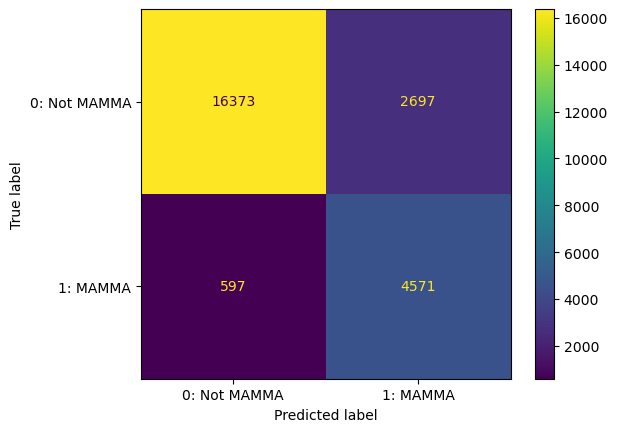

In [44]:
ConfusionMatrixDisplay.from_estimator(mod_comp_pipe, X_test, y_test, display_labels=["0: Not MAMMA", "1: MAMMA"]);

Predicts with 86% accuracy and a false positive rate of ~11%.